### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
!pip install parsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.0/556.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [parsl]32m7/8 [parsl]-sdk]


In [2]:
import parsl
from parsl import python_app
from parsl.config import Config
from parsl.executors.threads import ThreadPoolExecutor

parsl.clear()
config = Config(
    executors=[ThreadPoolExecutor(label="threads", max_threads=2)],
    strategy=None
)
parsl.load(config)

In [3]:
import numpy as np
from parsl import python_app

@python_app
def compute_local_centroids(X_chunk, centers):
    import numpy as np

    def assign_cluster(x, centers):
        return np.argmin([np.linalg.norm(x - c) for c in centers])
    
    labels = [assign_cluster(x, centers) for x in X_chunk]
    cluster_sums = [np.zeros_like(centers[0]) for _ in range(len(centers))]
    cluster_counts = [0] * len(centers)

    for i, label in enumerate(labels):
        cluster_sums[label] += X_chunk[i]
        cluster_counts[label] += 1
    
    return (cluster_sums, cluster_counts)


In [4]:
class Parallel_KMeans:
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def initial_centroid(self, X):
        return X[np.random.permutation(X.shape[0])[:self.n_clusters]]

    def fit(self, X, n_workers=4):
        n = X.shape[0]
        chunks = np.array_split(X, n_workers)
        centers = self.initial_centroid(X)

        for _ in range(self.max_iter):
            # Launch parallel tasks
            futures = [compute_local_centroids(chunk, centers) for chunk in chunks]
            results = [f.result() for f in futures]

            # Aggregate local centroids
            total_sums = [np.zeros_like(centers[0]) for _ in range(self.n_clusters)]
            total_counts = [0] * self.n_clusters

            for cluster_sums, cluster_counts in results:
                for j in range(self.n_clusters):
                    total_sums[j] += cluster_sums[j]
                    total_counts[j] += cluster_counts[j]

            # Update global centers
            new_centers = [total_sums[j] / total_counts[j] if total_counts[j] != 0 else centers[j]
                           for j in range(self.n_clusters)]
            new_centers = np.array(new_centers)

            # Convergence check
            if np.allclose(centers, new_centers):
                break
            centers = new_centers

        self.cluster_centers_ = centers
        return self


In [6]:
import pandas as pd
import numpy as np
import time
fraud3 = pd.read_csv('fraud3.csv')
fraud3 = np.array(fraud3)
kmeans = Parallel_KMeans(2, 300)
debut = time.time()
kmeans.fit(fraud3)
print(f'time = {time.time()-debut:.4f} secondes')

time = 110.2945 secondes
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124
Running on thread: 15124


In [34]:
import numpy as np
import os
import parsl
from parsl import python_app
from parsl.configs.local_threads import config
#parsl.load(config)

@python_app
def compute_local_centroids(X_chunk, centers):
    import numpy as np
    centers = np.array(centers)
    labels = np.argmin(np.linalg.norm(X_chunk[:, None] - centers[None, :], axis=2), axis=1)

    n_clusters = centers.shape[0]
    cluster_sums = np.zeros_like(centers)
    cluster_counts = np.zeros(n_clusters, dtype=np.int32)

    for k in range(n_clusters):
        members = X_chunk[labels == k]
        if len(members) > 0:
            cluster_sums[k] = members.sum(axis=0)
            cluster_counts[k] = len(members)

    return cluster_sums.tolist(), cluster_counts.tolist()

class OptimizedParallelKMeans:
    def __init__(self, n_clusters, max_iter, n_workers):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_workers = n_workers

    def initial_centroid(self, X):
        print('initializing centroids')
        return X[np.random.permutation(X.shape[0])[:self.n_clusters]]

    def fit(self, X):
        X = X.astype(np.float32)
        chunks = np.array_split(X, self.n_workers)
        centers = self.initial_centroid(X)
        print('begin training')

        for i in range(self.max_iter):
            futures = [compute_local_centroids(chunk, centers) for chunk in chunks]
            results = [f.result() for f in futures]  # Can use futures.wait() here for advanced sync

            total_sums = np.zeros_like(centers)
            total_counts = np.zeros(self.n_clusters, dtype=np.int32)

            for cluster_sums, cluster_counts in results:
                total_sums += np.array(cluster_sums)
                total_counts += np.array(cluster_counts)

            new_centers = np.divide(total_sums, total_counts[:, None], 
                                    out=np.copy(centers), where=total_counts[:, None] != 0)
        

            if np.allclose(centers, new_centers, atol=1e-4):
                break
            centers = new_centers
        print("iterations", i)

        self.cluster_centers_ = centers
        return self

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, None] - self.cluster_centers_[None, :], axis=2), axis=1)


In [23]:
import pandas as pd
import numpy as np
import time
fraud3 = pd.read_csv('fraud3.csv')
fraud3 = np.array(fraud3)
kmeans = OptimizedParallelKMeans(2, 300, 4)
debut = time.time()
kmeans.fit(fraud3)
print(f'time = {time.time()-debut:.4f} secondes')

initializing centroids
begin training
iterations 14
time = 0.3282 secondes


In [22]:
len(fraud3)

250000

In [24]:
from sklearn.metrics import silhouette_score

# Get predictions (cluster labels)
predicted_labels = kmeans.predict(fraud3)

# Compute silhouette score
score = silhouette_score(fraud3, predicted_labels)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.5297


In [25]:
from sklearn.metrics import davies_bouldin_score
dbi_score = davies_bouldin_score(fraud3, predicted_labels)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 0.6706


In [28]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(fraud3, predicted_labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 482392.5656


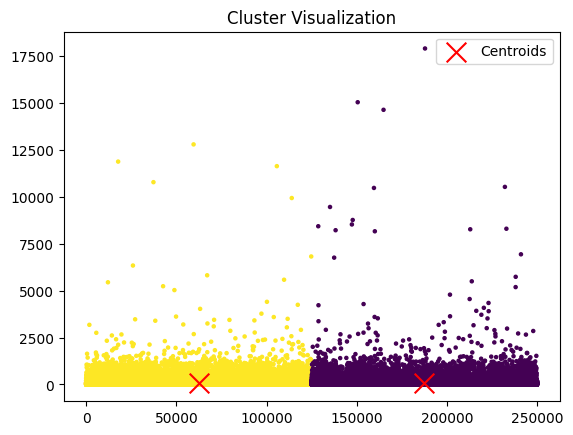

In [27]:
import matplotlib.pyplot as plt

plt.scatter(fraud3[:, 0], fraud3[:, 1], c=predicted_labels, cmap='viridis', s=5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            color='red', marker='x', s=200, label='Centroids')
plt.title("Cluster Visualization")
plt.legend()
plt.show()

In [29]:
import statistics
ss = []
for i in range(10):
    debut = time.time()
    kmeans.fit(fraud3)
    ss.append(time.time()-debut)
print(f'time = {statistics.mean(ss)} secondes')

initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 13
initializing centroids
begin training
iterations 12
initializing centroids
begin training
iterations 17
initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 11
initializing centroids
begin training
iterations 17
initializing centroids
begin training
iterations 16
initializing centroids
begin training
iterations 13
time = 0.4595562696456909 secondes


In [58]:
parsl.clear()
config = Config(
    executors=[ThreadPoolExecutor(label="threads", max_threads=2)],
    strategy=None
)
parsl.load(config)


In [55]:
fraud5 = pd.read_csv('fraud5.csv')
fraud5 = np.array(fraud5)

In [56]:
len(fraud5)

1000000

In [59]:
ss = []
for i in range(10):
    debut = time.time()
    kmeans.fit(fraud5)
    ss.append(time.time()-debut)
print(f'time = {statistics.mean(ss)} secondes')

initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 14
initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 15
initializing centroids
begin training
iterations 14
initializing centroids
begin training
iterations 12
initializing centroids
begin training
iterations 16
initializing centroids
begin training
iterations 16
initializing centroids
begin training
iterations 16
initializing centroids
begin training
iterations 15
time = 1.5888787984848023 secondes
